#Yewno Data Challenge
##Helen Craig
##Jan 14, 2015
You are given a realworld
undirected semantic graph represented via an adjacency matrix
wherein links encode similarity between concepts. You are asked to explore the ( emerging )
properties of such a graph (aka network ) in terms of its embedding on a surface with a given
genus by using the techniques provided in the references attached [<a href="Exploring_complex_networks_via_embedding_on_surfaces.pdf">1</a> ,<a href="Random_and_frozen_states_in_complex_triangulations.pdf">2</a>]. You are also asked to
infer potential connections between properties of hyperbolic embeddings and semantic
information hidden in the network.

##Paper Summary
In the two papers given as reference, the authors explore complex networks by modeling the system as a statistical mechanical description and manipulate the system via a 'temperature'.

##Reproducing Results
The following code reproduces some of the methods used in the above mentioned papers:

In [1]:
import csv
import math
import random
import matplotlib.pyplot as plt
import networkx as nx
import copy
import numpy
%matplotlib inline

###Helper function for organizing keys for edge array

In [2]:
def reorder(a,b):
    if a>b:
        c=a
        a=b
        b=c
    return a,b

###Function for loading the data

In [3]:
def loadData(name):#this function loads the data
    entries = list(csv.reader(open(name, 'rb'),delimiter='\t'))
    dic={}
    for entry in entries:
        dic[(entry[0],entry[1])]=entry[2]
    dicSingles={}#we create a dictionary where the keys are the
    for key in dic.keys():#various words and the items are the 
        if key[0] in dicSingles.keys():#words connected to the keys
            if key[1] not in dicSingles[key[0]]:
                dicSingles[key[0]].append(key[1])
        else:
            dicSingles[key[0]]=[key[1]]

        if key[1] in dicSingles.keys():
            if key[0] not in dicSingles[key[1]]:
                dicSingles[key[1]].append(key[0])
        else:
            dicSingles[key[1]]=[key[0]]
            
    dicDoubles={}#we create a dictionary where the key is a edge
    for key in dicSingles.keys():#and the items are the 
        for item in dicSingles[key]:#
            a,b=reorder(key,item)
            newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
            if (a,b) not in dicDoubles.keys():
                    dicDoubles[(a,b)]=newItems
    return (dicSingles,dicDoubles)

###Function for pruning data with nodes in keepList and their neighbors

In [4]:
def pruneData(dicSingles,dicDoubles,keepList):
    dicSingles2={}
    keepList2=list(keepList)
    for i in keepList:
        for j in keepList:
            if i!=j:
                a,b=reorder(i,j)
                if (a,b) in dicDoubles.keys():
                    for item in dicDoubles[(a,b)]:
                        if item not in keepList2:
                            keepList2.append(item)
    dicSingles2={}
    for i in keepList2:
        for item in dicSingles[i]:
            if item in keepList2:
                if i in dicSingles2.keys():
                    dicSingles2[i].append(item)
                else:
                    dicSingles2[i]=[item]
                
    dicDoubles2={}#we create a dictionary where the key is a edge
    for key in dicSingles2.keys():#and the items are the 
        for item in dicSingles2[key]:#
            a,b=reorder(key,item)
            newItems=list(set(dicSingles2[a]).intersection(dicSingles2[b]))
            if (a,b) not in dicDoubles2.keys():
                    dicDoubles2[(a,b)]=newItems
    return dicSingles2,dicDoubles2

###Function for pruning data with nodes in keepList 

In [5]:
def pruneData2(dicSingles,dicDoubles,keepList):
    dicSingles2={}
    for i in keepList:
        dicSingles2[i]=[]
    for key in keepList:
        if key in dicSingles.keys():
            for item in dicSingles[key]:
                if item in keepList:
                    if key in dicSingles2.keys():
                        dicSingles2[key].append(item)
                    else:
                        dicSingles2[key]=[item]
        else:
            dicSingles2[key]=[]
    dicDoubles2={}#we create a dictionary where the key is a edge
    for key in dicSingles2.keys():#and the items are the 
        for item in dicSingles2[key]:#
            a,b=reorder(key,item)
            newItems=list(set(dicSingles2[a]).intersection(dicSingles2[b]))
            if (a,b) not in dicDoubles2.keys():
                    dicDoubles2[(a,b)]=newItems    
    return dicSingles2,dicDoubles2    

###Function for calculating the average k
Here k is the number of incident edges for a given vertex

In [6]:
def calcKavrg(dicSingles):
    tot=0
    for item in dicSingles.items():
        tot+=len(item[1])
    return float(tot)/float(len(dicSingles))

###Function for calculating energy of the graph
The energy is defined as: $E=\sum^n_{i=1}(k_i-\bar{k})^2$ where n is the number of vertices and $\bar{k}$ is the average k value.

In [7]:
def calcEnergy(dicSingles,kAvg):
    tot=0
    for item in dicSingles.items():
        tot+=pow(len(item[1])-kAvg,2)
    return tot

###Function for removing one edge and inserting another edge
This is the move T1 discussed in the linked papers.  Visually the move is:
<img src="T1.png">

In [8]:
def makeMove(dicSingles,dicDoubles,oldLink,newLink):
    del dicDoubles[oldLink]#delete the link
    dicSingles[oldLink[0]].remove(oldLink[1])#remove link
    dicSingles[oldLink[1]].remove(oldLink[0])#from the two previously linked nodes
    for item in dicSingles[oldLink[0]]:#for one of the old nodes
        a=oldLink[0]#remove the link to the third node
        b=item
        a,b=reorder(a,b)
        if (a,b) in dicDoubles.keys():
            if oldLink[1] in dicDoubles[(a,b)]:
                dicDoubles[(a,b)].remove(oldLink[1])
    for item in dicSingles[oldLink[1]]:#same for the other node
        a=oldLink[1]
        b=item
        a,b=reorder(a,b)
        if (a,b) in dicDoubles.keys():
            if oldLink[0] in dicDoubles[(a,b)]:
                dicDoubles[(a,b)].remove(oldLink[0])
    #########################################       
    dicSingles[newLink[0]].append(newLink[1])#add the new link to the 
    dicSingles[newLink[1]].append(newLink[0])#individual lists
    a=newLink[0]
    b=newLink[1]
    a,b=reorder(a,b)
    newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
    dicDoubles[(a,b)]=newItems#add to the link list and the third connections
    for item in dicSingles[newLink[0]]:
        a,b=reorder(item,newLink[0])
        newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
        dicDoubles[(a,b)]=newItems#add to the link list the any other new connections
    for item in dicSingles[newLink[1]]:
        a,b=reorder(item,newLink[1])
        newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
        dicDoubles[(a,b)]=newItems#same with the other new point      

###Function for stepping through the graph to make suggested moves.  
This function steps through the graph looking for edges where a T1 move is possible.  If one is found, the change in energy of such a move is calculated ($\Delta E=2(k_a+k_c-k_b-k_d)+4$) and is accepted with probability $\frac{1}{1+\exp{(\beta \Delta E)}}(1-\delta_{k_b,3})(1-\delta_{k_d,3})(1-\delta_{a,c})$ where $T=1/\beta$, a 'temperature' of the system.

In [9]:
def stepThroughGraph(dicSingles,dicDoubles,beta):
    totE=0
    totMoves=0
    oldKeys=dicDoubles.keys()#list of old links
    for oldKey in oldKeys:#step through them
        oldTriangles=dicDoubles[oldKey]#list of triangles that the link is a part of
        if len(dicSingles[oldKey[0]])>3 and len(dicSingles[oldKey[1]])>3 and len(oldTriangles)>1:
            for oldTriangleIndex in range(len(oldTriangles)):
                r1=random.randrange(0, len(oldTriangles))#randomly select two of the triangles
                r2=random.randrange(0, len(oldTriangles))
                if r1!=r2:#if they are not the same triangle
                    a,b=reorder(oldTriangles[r1],oldTriangles[r2])
                    if (a,b) not in dicDoubles.keys():#if the link does not already exist
                        ka=len(dicSingles[oldTriangles[r1]])
                        kc=len(dicSingles[oldTriangles[r2]])
                        kd=len(dicSingles[oldKey[0]])
                        kb=len(dicSingles[oldKey[1]])
                        deltaE=2*(ka+kc-kd-kb)+4#calc the change in energy
                        totE+=deltaE
                        if deltaE*beta>200:
                            prob=0
                        else:    
                            prob=1/(1+math.exp(deltaE*beta))
                        r=random.random()
                        totMoves+=1
                        if prob>r:#calc if we make the move
                                oldLink=oldKey
                                newLink=(oldTriangles[r1],
                                        oldTriangles[r2])#make the move
                                makeMove(dicSingles,dicDoubles,oldLink,newLink)
                                break;#exit the loop
    return totMoves


###Function for calculating the genus of a given graph

In [10]:
def calcGenus(dicSingles,dicDoubles):
    numVertices=len(dicSingles)
    numEdges=len(dicDoubles)
    numTriangles=0
    for key in dicDoubles.keys():
        numTriangles+=len(dicDoubles[key])
    return 1-(numVertices-numEdges+numTriangles/3)/2.0

###Function for plotting a graph

In [11]:
def draw_graph(graph):

    # extract nodes from graph
    nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])

    # create networkx graph
    G=nx.Graph()

    # add nodes
    for node in nodes:
        G.add_node(node)

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # draw graph
    pos = nx.shell_layout(G)
    plt.figure(3,figsize=(20,20)) 
    nx.draw(G, pos,with_labels=True,font_size=20)
    # show graph
    plt.show()

###Load the file of first months data

In [12]:
dicSingles,dicDoubles=loadData("net1.dat")#load data

###Prune data to a list of words plus those words connecting these words.

In [13]:
keepList=['morgan_stanley',
         'rbs',
          'jp_morgan',
         ]
dicSingles2,dicDoubles2=pruneData(dicSingles,dicDoubles,keepList)


###Calculate the average k and the energy of the system

In [14]:
kAvg=calcKavrg(dicSingles2)#calc kAvg
print kAvg
print calcEnergy(dicSingles2,kAvg)

13.2142857143
790.714285714


###function for calculating the number of vertices, edges, and triangles of a graph

In [15]:
def CalcVerticesEdgesTrianglesGenus(dicSingles,dicDoubles):
    numVertices=len(dicSingles)
    numEdges=len(dicDoubles)
    numTriangles=0
    for key in dicDoubles.keys():
        numTriangles+=len(dicDoubles[key])
    print "# vertices",numVertices
    print "# edges",numEdges
    print "# triangles",numTriangles,"/ 3 =",numTriangles/3
    print "# genus",1-(numVertices-numEdges+numTriangles/3)/2.0
CalcVerticesEdgesTrianglesGenus(dicSingles2,dicDoubles2)

# vertices 28
# edges 185
# triangles 1665 / 3 = 555
# genus -198.0


###Plot of the graph

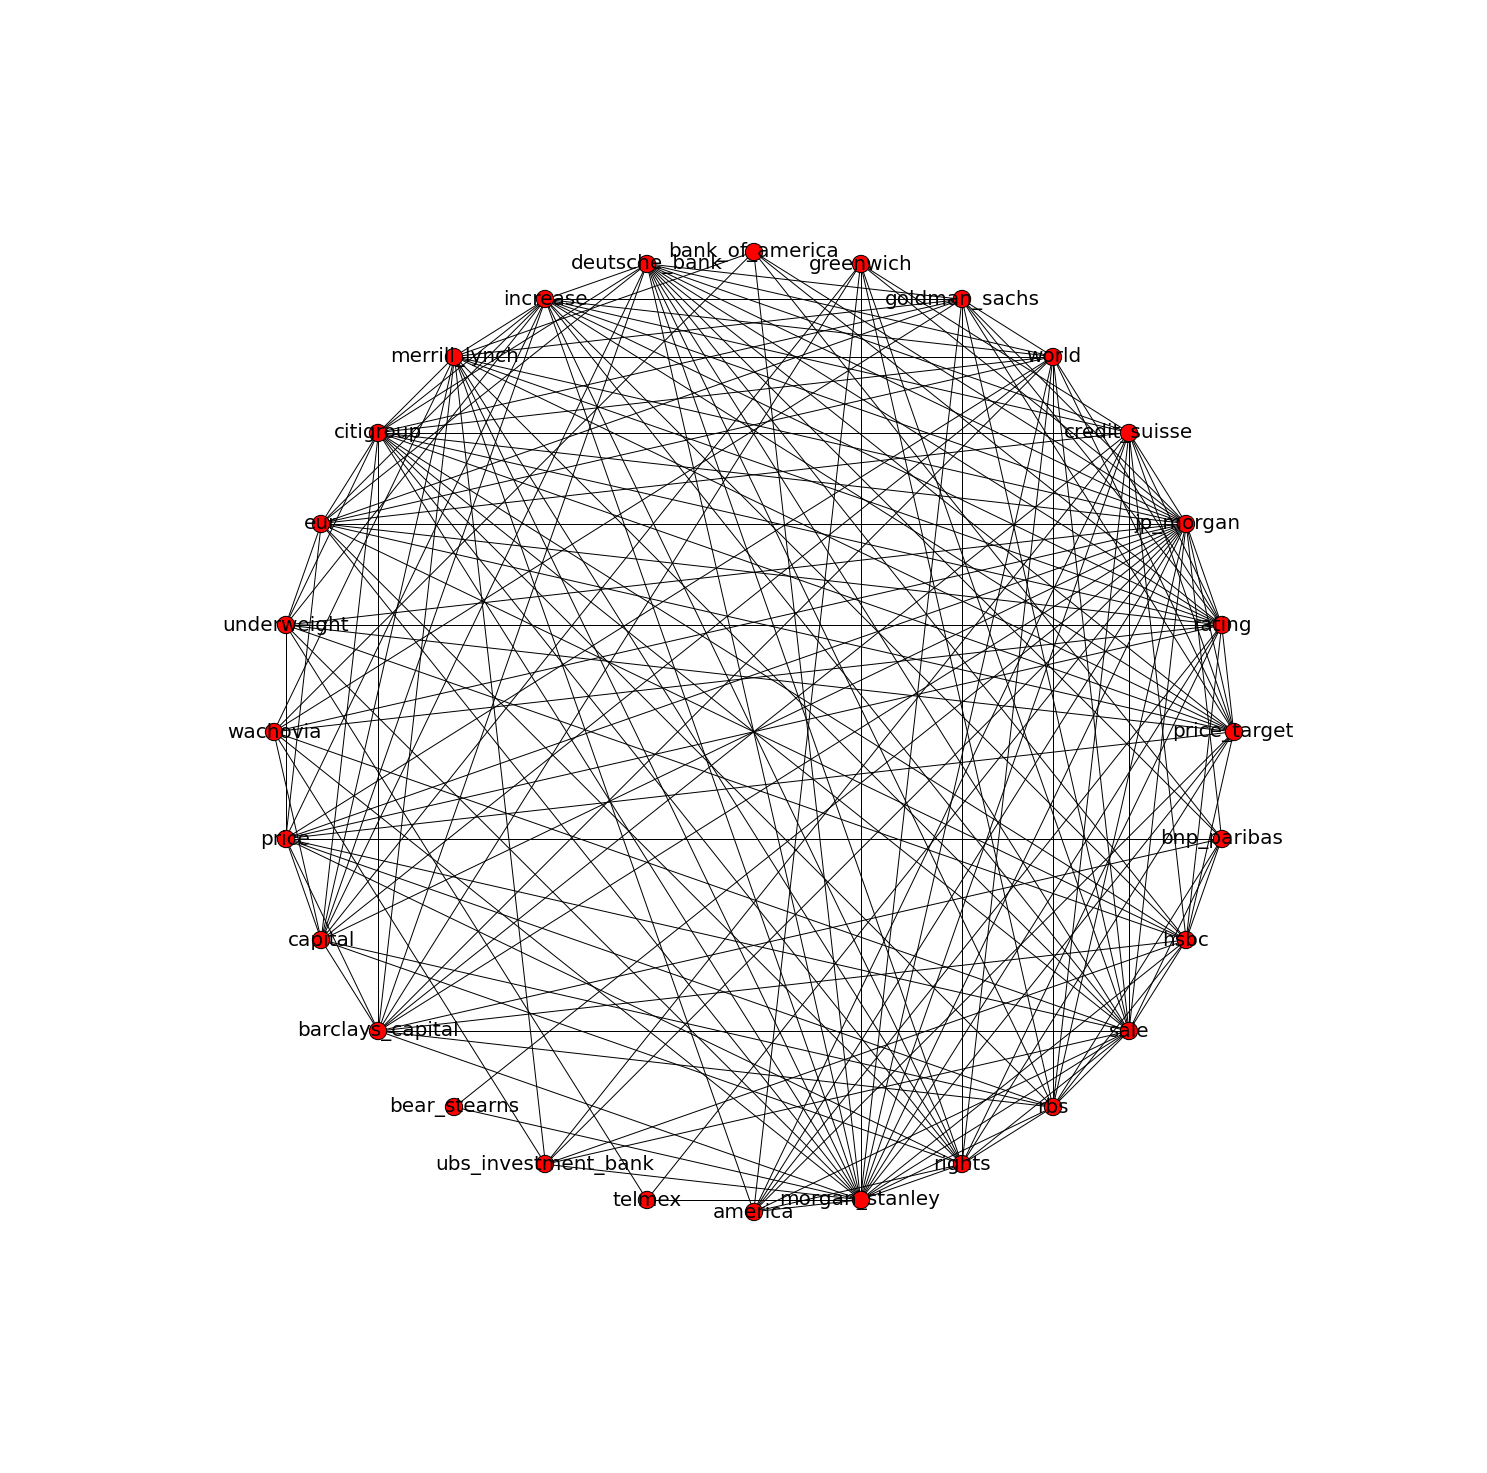

In [16]:
draw_graph(sorted(dicDoubles2.keys()))


###running the code for different $\beta$

below is the code for running the simulation with different $\beta$ values.  

In [17]:
betas=['10','1','0.1','0.01','0.001','0.000001']
steps=range(500)
energyArray={'10':[],'1':[],'0.1':[],'0.01':[],'0.001':[],'0.000001':[]}
stepsArray={'10':[],'1':[],'0.1':[],'0.01':[],'0.001':[],'0.000001':[]}

for beta in betas:
    totSteps=0
    dicSingles3=copy.deepcopy(dicSingles2)
    dicDoubles3=copy.deepcopy(dicDoubles2)#load data
    for step in steps:
        totSteps+=stepThroughGraph(dicSingles3,dicDoubles3,float(beta))
        energyArray[beta].append(calcEnergy(dicSingles3,kAvg)/len(dicSingles3))
        stepsArray[beta].append(totSteps)
        #print beta,step,totSteps,calcEnergy(dicSingles3,kAvg), calcGenus(dicSingles3,dicDoubles3)

###plot for different betas, evolution of energy versus steps.

From the plot below we see that the energy is still decreasing for the $\beta$'s, most notably for $\beta=10$.

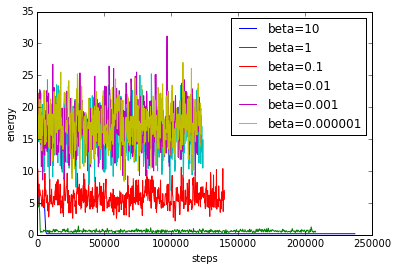

In [18]:
for beta in betas:
    plt.plot(stepsArray[beta],energyArray[beta],label='beta='+beta)
    plt.xlabel('steps')
    plt.ylabel('energy')
    plt.legend()
plt.show()

###The final energy versus $\beta$

The final energy decreases for smaller temperatures (larger $\beta$).

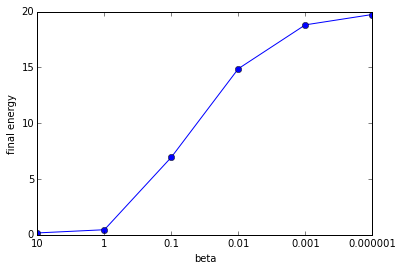

In [19]:
x=range(len(betas))
plt.plot(x,[energyArray[beta][-1] for beta in betas],'o-')
plt.xticks(x, betas)
plt.xlabel('beta')
plt.ylabel('final energy')

###Simulated annealing
We can also try doing a simulated annealing scheme.

In [20]:
def simAnneal(dicSingles2,dicDoubles2):
    steps=range(200)
    beta=0.1
    dicSingles3=copy.deepcopy(dicSingles2)
    dicDoubles3=copy.deepcopy(dicDoubles2)#load dataenergyArray2=[]
    stepsArray2=[]
    betaMult=1.05
    totSteps2=0
    energyArray2=[]
    stepsArray2=[]
    kAvg=calcKavrg(dicSingles2)
    for step in steps:
        totSteps2+=stepThroughGraph(dicSingles3,dicDoubles3,beta)
        energyArray2.append(calcEnergy(dicSingles3,kAvg)/len(dicSingles3))
        stepsArray2.append(totSteps2)
        beta=beta*betaMult
    return stepsArray2,energyArray2,dicSingles3,dicDoubles3

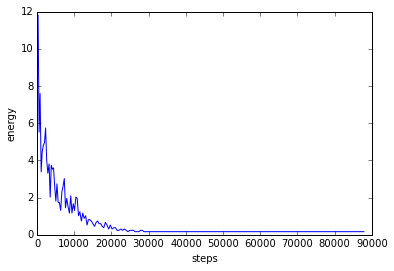

In [21]:
stepsArray2,energyArray2,dicSingles3,dicDoubles3=simAnneal(dicSingles2,dicDoubles2)
plt.plot(stepsArray2,energyArray2)
plt.xlabel('steps')
plt.ylabel('energy')

###Plot of low temperature graph
At low temperature, the graph has much more evenly distributed links as can be seen in the graph below.

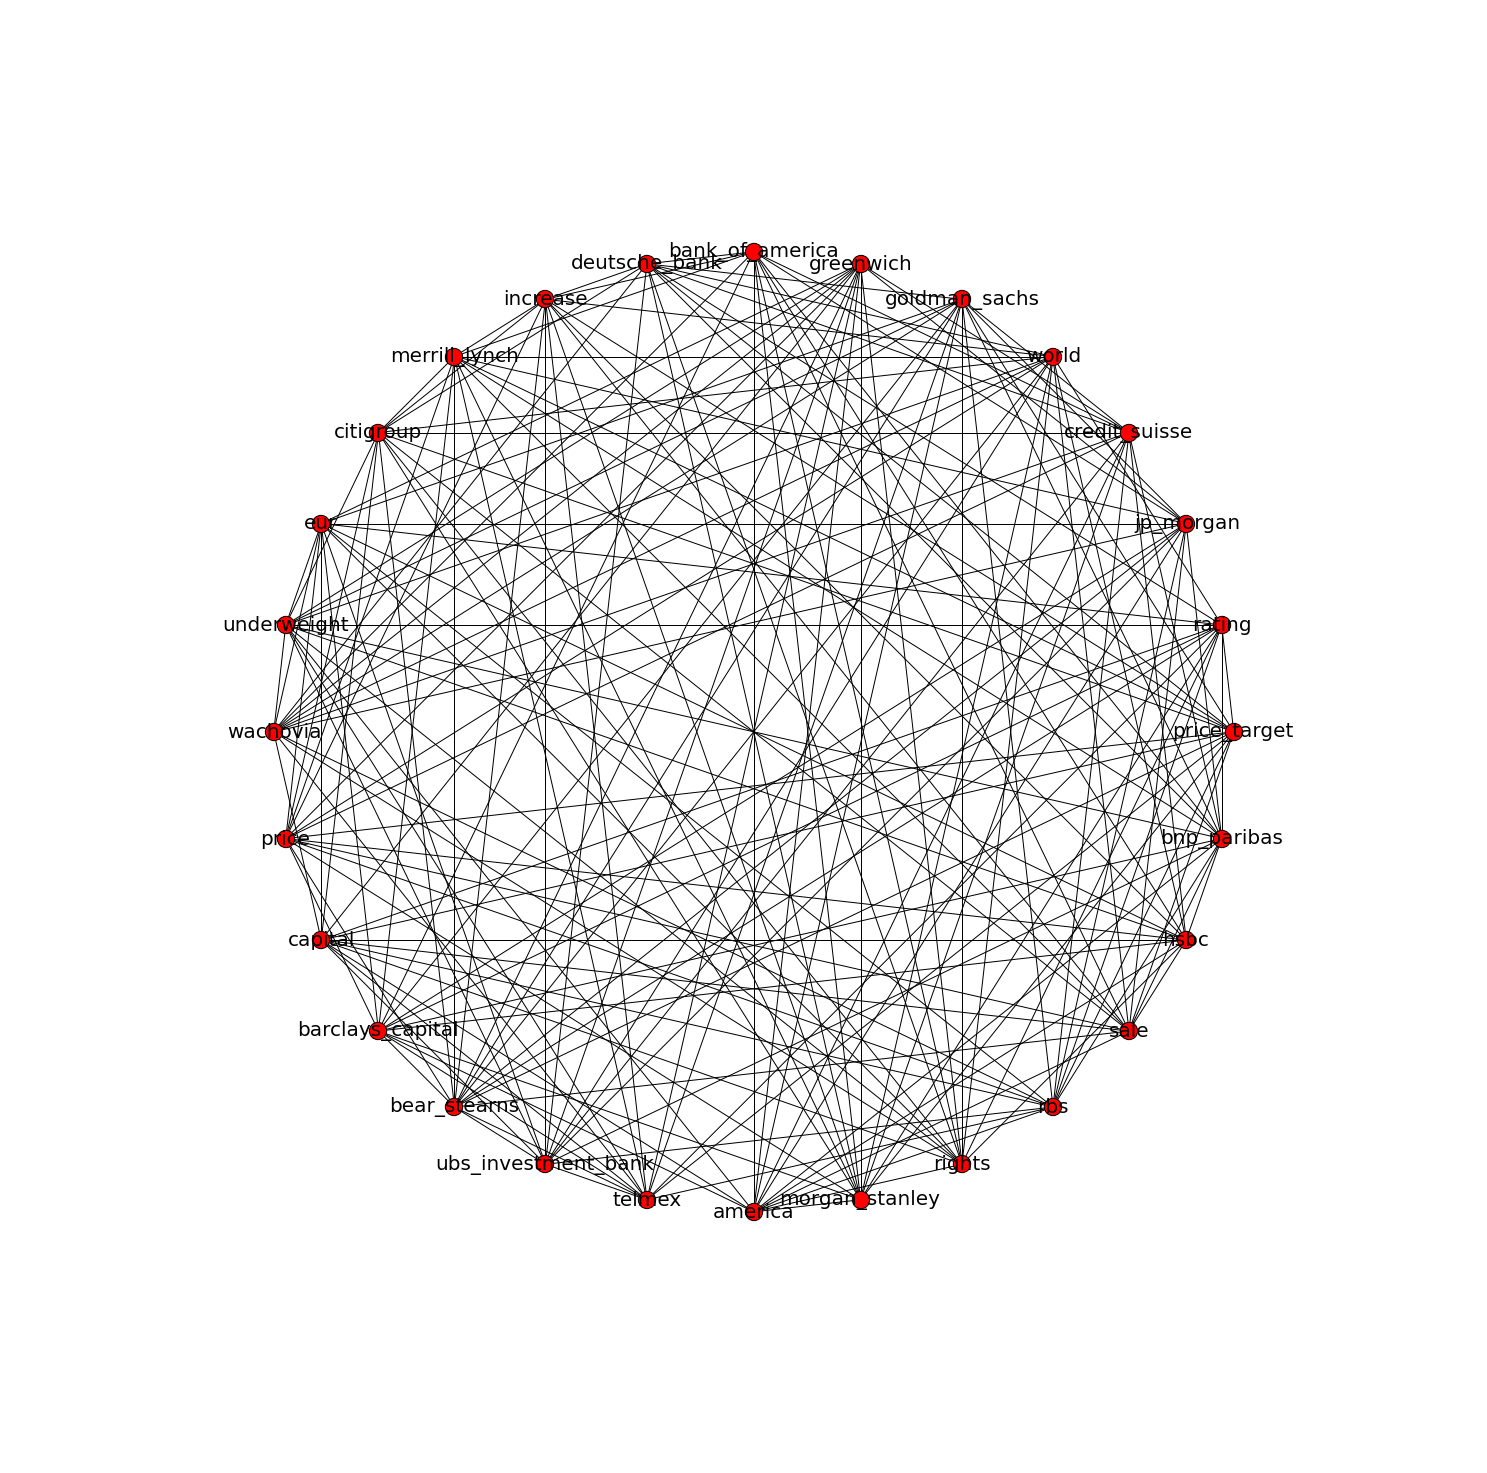

In [22]:
draw_graph(sorted(dicDoubles3.keys()))

###Dataset of the second month
We can do a similar analysis on the second data set:

In [23]:
dicSinglesDeltat,dicDoublesDeltat=loadData("net2.dat")#load data

###Load second graph with the same nodes as the first graph

In [24]:
dicSinglesDeltat2,dicDoublesDeltat2=pruneData2(dicSinglesDeltat,dicDoublesDeltat,dicSingles2.keys())

###Apply simulated annealing to the second graph

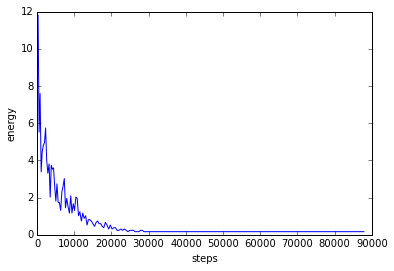

In [25]:
stepsArrayDeltat2,energyArrayDeltat2,dicSinglesDeltat3,dicDoublesDeltat3=simAnneal(dicSinglesDeltat2,dicDoublesDeltat2)
plt.plot(stepsArray2,energyArray2)
plt.xlabel('steps')
plt.ylabel('energy')

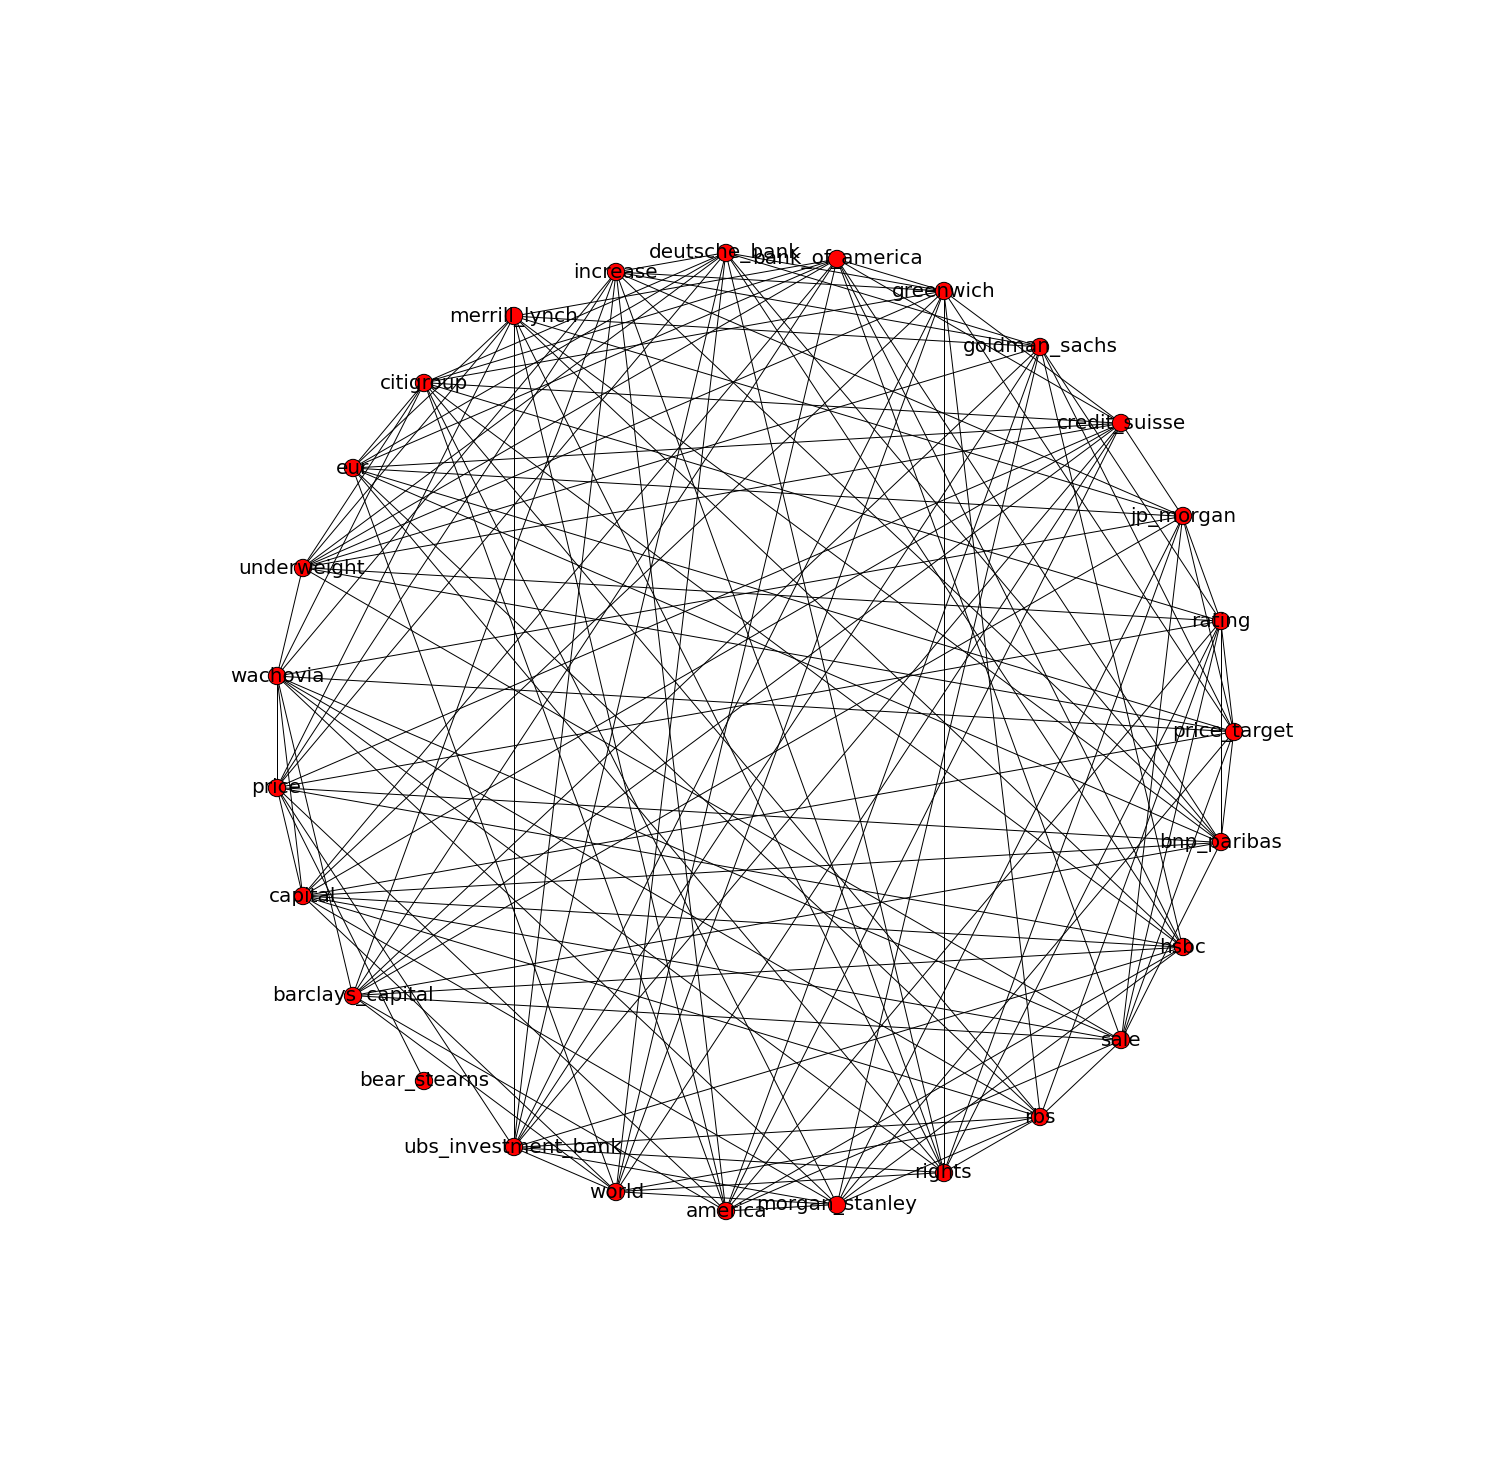

In [26]:
draw_graph(sorted(dicDoublesDeltat3.keys()))

###What connections we expect to see in the next month for 'morgan_stanley'

In [44]:
stepsArray2,energyArray2,dicSingles3,dicDoubles3=simAnneal(dicSingles2,dicDoubles2)
sorted(set(dicSingles3['morgan_stanley'])-set(dicSingles2['morgan_stanley']))

['bnp_paribas', 'price']

###What connections actually arrose

In [45]:
sorted(set(dicSinglesDeltat2['morgan_stanley'])-set(dicSingles2['morgan_stanley']))

['price']

###What connections we expect to see in the next month for 'rbs'

In [46]:
sorted(set(dicSingles3['rbs'])-set(dicSingles2['rbs']))

['bank_of_america',
 'goldman_sachs',
 'price_target',
 'rating',
 'underweight',
 'wachovia']

###What connections actually arrose

In [47]:
sorted(set(dicSinglesDeltat2['rbs'])-set(dicSingles2['rbs']))

['eur', 'price_target', 'rating']

###What connections we expect to see in the next month for 'jp_morgan'

In [48]:
sorted(set(dicSingles3['jp_morgan'])-set(dicSingles2['jp_morgan']))

['hsbc', 'world']

###What connections actually arrose

In [49]:
sorted(set(dicSinglesDeltat2['jp_morgan'])-set(dicSingles2['jp_morgan']))

['world']

###Conclusions

A statistical physics framework can be used to decrease the number of edges in a graph by means of a temperature.  This has important implications for information filtering. 

For instance, we can predict which first degree connections will appear in the graph of the following month by looking at the zero temperature graph of the previous month.

Further, one can use common techniques such as simulated annealing, parallel tempering (e.g. http://people.math.umass.edu/~rsellis/pdf-files/parallel-tempering-paper.pdf), or perhaps a modified diffusion monte carlo method (e.g. http://arxiv.org/pdf/physics/9702023v1.pdf).

Overall, I was limited by the memory on my laptop.  One solution to this would be using a AWS machine to do my work.

Further this work could also be parallelized using C++ MPI library.  In genral, the algorithms will run faster if implemented in C++ or C.  The data could be divided up into clusters and processed on seperate cores.